In [1]:
import numpy as np
import pandas as pd
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
class OHLCV:
    def __init__(self, o, h, l, c, v, t=None):
        self.open = o
        self.high = h
        self.low = l
        self.close = c
        self.volume = v
        self.time = t

# Raw Data from Indodax

In [3]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'

def get_raw(period, begin, end):
    chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, begin, end)
    raw = requests.get(root_uri_chart_api + chart_query).json()
    return OHLCV(
        np.array(raw['o']),
        np.array(raw['h']),
        np.array(raw['l']),
        np.array(raw['c']),
        np.array(raw['v']),
        t=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), raw['t']))
    )


In [4]:
train_set = get_raw(5, int(datetime.datetime(2015, 11, 1).timestamp()), int(datetime.datetime(2016, 5, 1).timestamp()))

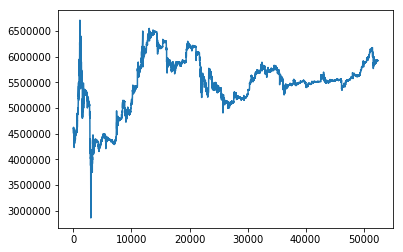

In [5]:
plt.plot(train_set.close)

In [6]:
test_up_set = get_raw(5, int(datetime.datetime(2017, 10, 1).timestamp()), int(datetime.datetime(2017, 12, 1).timestamp()))

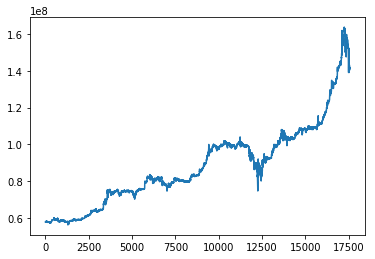

In [7]:
plt.plot(test_up_set.close)

In [8]:
test_down_set = get_raw(5, int(datetime.datetime(2018, 1, 1).timestamp()), int(datetime.datetime(2018, 3, 1).timestamp()))

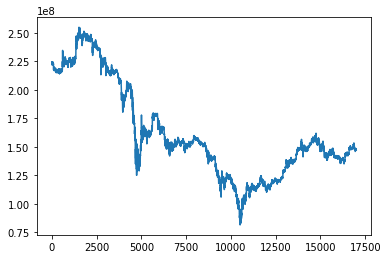

In [9]:
plt.plot(test_down_set.close)

In [10]:
test_updown_set = get_raw(5, int(datetime.datetime(2016, 8, 10).timestamp()), int(datetime.datetime(2016, 10, 10).timestamp()))

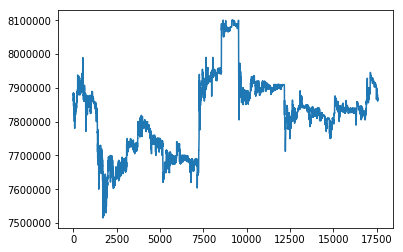

In [11]:
plt.plot(test_updown_set.close)

In [164]:
EPS = 1e-6
BUY = -1
HOLD = 0
SELL = 1
commission = 0.003
back = 8

# Label Method 1

In [165]:
def get_label_1(raw, look_back, margin):
    action = np.array([HOLD for i in range(len(raw.close))], dtype=np.int16)
    for i in range(look_back, len(raw.close)-1):
        current = raw.close[i]
        before = raw.close[i-1]
        after = raw.close[i+1]
        if current * (1 + margin) < after:
            if before * (1 + margin) < current:
                action[i] = HOLD
            else:
                action[i] = BUY
        elif current > after * (1 + margin):
            if before > current * (1 + margin):
                action[i] = HOLD
            else:
                action[i] = SELL
        else:
            action[i] = HOLD
    return action[look_back:]

# Label Method 2
A little more relaxed

In [62]:
def get_label_2(raw, look_back, margin):
    action = get_label_1(raw, look_back, margin)
    i = 0
    while i < len(action):
        if action[i] == BUY:
            for j in range(3):
                if i+j+1 >= len(action) or action[i+j+1] == SELL:
                    break
                action[i+j+1] = BUY
                i += 1
        else:
            i += 1
        if i >= len(action):
            break
        if action[i] == SELL:
            for j in range(3):
                if i+j+1 >= len(action) or action[i+j+1] == BUY:
                    break
                action[i+j+1] = SELL
                i += 1
        else:
            i += 1
    return action

# Label Method 3

In [88]:
def get_label_3(raw, look_back, margin):
    action = np.array([HOLD for i in range(len(raw.close))])
    min_net_profit = lambda p: p * (1+(2*commission))
    for i in range(look_back*2, len(raw.close)):
        # sample the future
        sample = np.array([raw.close[i-j] for j in range(5)])
        if (sample > min_net_profit(raw.close[i-look_back])).sum() > 4:
            action[i-look_back] = BUY
            action[i] = SELL
    return action[look_back:]

# Label Method 4

In [159]:
def get_label_4(raw, look_back, margin):
    buys = np.array([0.0 for i in range(len(raw.close))], dtype=np.float64)
    sells = np.array([0.0 for i in range(len(raw.close))], dtype=np.float64)
    min_net_profit = lambda p: p * (1+(2*commission))
    for i in range(look_back*2, len(raw.close)):
        # sample the future
        sample = np.array([raw.close[i-j] for j in range(5)])
        if (sample > min_net_profit(raw.close[i-look_back])).sum() > 4:
            buys[i-look_back] = 1.0
            sells[i] = 1.0
            # buy earlier
            p = i-look_back-1
            x = 1.0-(1.0/float(look_back))
            while p >= i-2*look_back-1:
                if x < buys[p]:
                    break
                buys[p] = x
                x -= (1.0/float(look_back))
                p -= 1
            # sell later
            p = i
            x = 1.0-(1.0/float(look_back))
            while p < i + look_back:
                sells[p] = x
                x -= (1.0/float(look_back))
                p += 1
    return buys[look_back:], sells[look_back:]

In [160]:
b, s = get_label_4(train_set, back, commission)

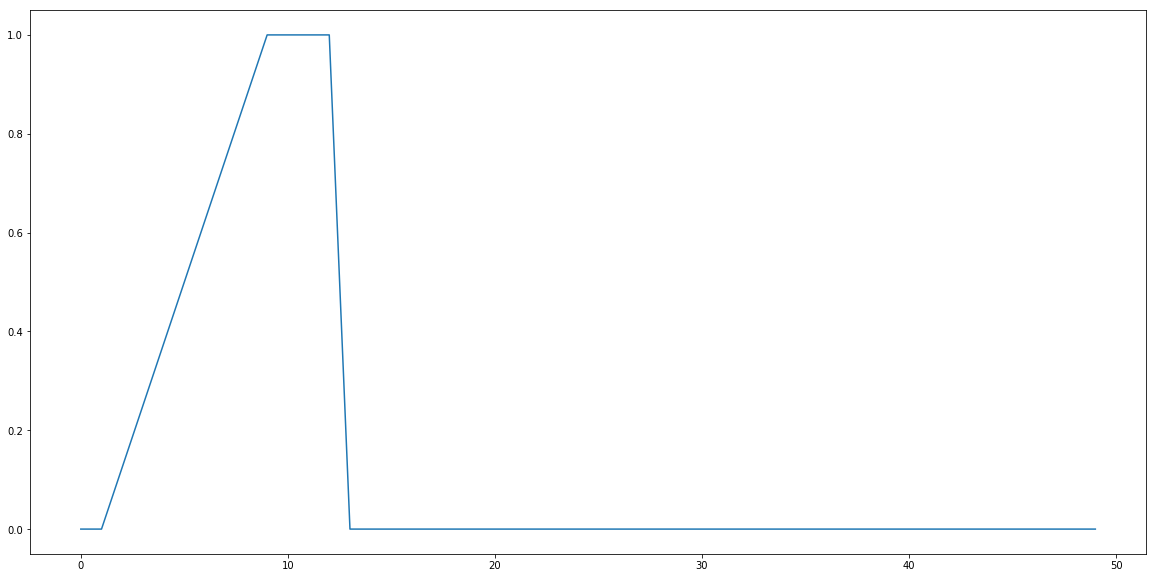

In [163]:
plt.figure(figsize=(20,10))
m = 500
plt.plot(b[m:m+50])

In [166]:
label_train = get_label_1(train_set, back, commission)
label_up_test = get_label_1(test_up_set, back, commission)
label_down_test = get_label_1(test_down_set, back, commission)
label_updown_test = get_label_1(test_updown_set, back, commission*2)

In [92]:
label_train = get_label_3(train_set, back, commission)
label_up_test = get_label_3(test_up_set, back, commission)
label_down_test = get_label_3(test_down_set, back, commission)
label_updown_test = get_label_3(test_updown_set, back, commission)

In [167]:
np.savetxt('y_train_label1.csv', label_train+1, delimiter=',')
np.savetxt('y_up_test_label1.csv', label_up_test+1, delimiter=',')
np.savetxt('y_down_test_label1.csv', label_down_test+1, delimiter=',')
np.savetxt('y_updown_test_label1.csv', label_updown_test+1, delimiter=',')

In [60]:
np.savetxt('y_train_label2.csv', label_train+1, delimiter=',')
np.savetxt('y_up_test_label2.csv', label_up_test+1, delimiter=',')
np.savetxt('y_down_test_label2.csv', label_down_test+1, delimiter=',')
np.savetxt('y_updown_test_label2.csv', label_updown_test+1, delimiter=',')

In [113]:
np.savetxt('y_train_label3.csv', label_train+1, delimiter=',')
np.savetxt('y_up_test_label3.csv', label_up_test+1, delimiter=',')
np.savetxt('y_down_test_label3.csv', label_down_test+1, delimiter=',')
np.savetxt('y_updown_test_label3.csv', label_updown_test+1, delimiter=',')

In [169]:
label_train.shape

(52409,)

In [48]:
np.where(label_train == SELL)[0].shape

(3095,)

# Backtrading

In [26]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [27]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # weird workaround due to limitation to column name
        # we take the low column as action
        self.data_action = self.datas[0].low
        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                self.opsize = order.executed.size
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                gross_pnl = (order.executed.price - self.buyprice) * \
                    self.opsize

                net_pnl = gross_pnl - self.buycomm - order.executed.comm
                self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                         (gross_pnl, net_pnl))


            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy!
            if self.data_action[0] == -1:
                self.log('BUY CREATE')
                self.order = self.buy()

        else:
            # sell!
            if self.data_action[0] == 1:
                self.log('SELL CREATE')
                self.order = self.sell()

In [93]:
action_frame_train = pd.DataFrame({
    'low': label_train,
    'close': train_set.close[back:],
    'open': train_set.open[back:],
    'high': train_set.high[back:],
}, index=train_set.time[back:])

In [94]:
action_frame_up = pd.DataFrame({
    'low': label_up_test,
    'close': test_up_set.close[back:],
    'open': test_up_set.open[back:],
    'high': test_up_set.high[back:],
}, index=test_up_set.time[back:])

In [95]:
action_frame_down = pd.DataFrame({
    'low': label_down_test,
    'close': test_down_set.close[back:],
    'open': test_down_set.open[back:],
    'high': test_down_set.high[back:],
}, index=test_down_set.time[back:])

In [96]:
action_frame_updown = pd.DataFrame({
    'low': label_updown_test,
    'close': test_updown_set.close[back:],
    'open': test_updown_set.open[back:],
    'high': test_updown_set.high[back:],
}, index=test_updown_set.time[back:])

In [217]:
y_res = np.loadtxt('gboost_pred_updown.csv', delimiter=',') - 1
action_frame_res = pd.DataFrame({
    'low': y_res,
    'close': test_updown_set.close[back:],
    'open': test_updown_set.open[back:],
    'high': test_updown_set.high[back:],
}, index=test_updown_set.time[back:])

In [218]:
data_feed = btfeeds.PandasData(dataname=action_frame_res, openinterest=None)

cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
# cerebro.adddata(action_frame)
cerebro.broker.setcash(250 * 10**6)
cerebro.broker.setcommission(commission=commission)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 250000000.00
2016-08-10, BUY CREATE
2016-08-10, BUY EXECUTED, Price: 7845600.00, Cost: 7845600.00, Comm 23536.80
2016-08-10, SELL CREATE
2016-08-10, SELL EXECUTED, Price: 7874800.00, Cost: 7845600.00, Comm 23624.40
2016-08-10, OPERATION PROFIT, GROSS 29200.00, NET -17961.20
2016-08-10, BUY CREATE
2016-08-10, BUY EXECUTED, Price: 7863100.00, Cost: 7863100.00, Comm 23589.30
2016-08-10, SELL CREATE
2016-08-10, SELL EXECUTED, Price: 7875200.00, Cost: 7863100.00, Comm 23625.60
2016-08-10, OPERATION PROFIT, GROSS 12100.00, NET -35114.90
2016-08-10, BUY CREATE
2016-08-10, BUY EXECUTED, Price: 7845600.00, Cost: 7845600.00, Comm 23536.80
2016-08-10, SELL CREATE
2016-08-10, SELL EXECUTED, Price: 7869900.00, Cost: 7845600.00, Comm 23609.70
2016-08-10, OPERATION PROFIT, GROSS 24300.00, NET -22846.50
2016-08-10, BUY CREATE
2016-08-10, BUY EXECUTED, Price: 7845500.00, Cost: 7845500.00, Comm 23536.50
2016-08-10, SELL CREATE
2016-08-10, SELL EXECUTED, Price: 7869100.00, Cost:

2016-08-12, BUY EXECUTED, Price: 7866600.00, Cost: 7866600.00, Comm 23599.80
2016-08-12, SELL CREATE
2016-08-12, SELL EXECUTED, Price: 7884600.00, Cost: 7866600.00, Comm 23653.80
2016-08-12, OPERATION PROFIT, GROSS 18000.00, NET -29253.60
2016-08-12, BUY CREATE
2016-08-12, BUY EXECUTED, Price: 7865100.00, Cost: 7865100.00, Comm 23595.30
2016-08-12, SELL CREATE
2016-08-12, SELL EXECUTED, Price: 7871100.00, Cost: 7865100.00, Comm 23613.30
2016-08-12, OPERATION PROFIT, GROSS 6000.00, NET -41208.60
2016-08-12, BUY CREATE
2016-08-12, BUY EXECUTED, Price: 7870800.00, Cost: 7870800.00, Comm 23612.40
2016-08-12, SELL CREATE
2016-08-12, SELL EXECUTED, Price: 7866600.00, Cost: 7870800.00, Comm 23599.80
2016-08-12, OPERATION PROFIT, GROSS -4200.00, NET -51412.20
2016-08-12, BUY CREATE
2016-08-12, BUY EXECUTED, Price: 7865700.00, Cost: 7865700.00, Comm 23597.10
2016-08-12, SELL CREATE
2016-08-12, SELL EXECUTED, Price: 7865800.00, Cost: 7865700.00, Comm 23597.40
2016-08-12, OPERATION PROFIT, GROSS 

2016-08-14, BUY CREATE
2016-08-14, BUY EXECUTED, Price: 7843900.00, Cost: 7843900.00, Comm 23531.70
2016-08-14, SELL CREATE
2016-08-14, SELL EXECUTED, Price: 7840800.00, Cost: 7843900.00, Comm 23522.40
2016-08-14, OPERATION PROFIT, GROSS -3100.00, NET -50154.10
2016-08-14, BUY CREATE
2016-08-14, BUY EXECUTED, Price: 7834900.00, Cost: 7834900.00, Comm 23504.70
2016-08-14, SELL CREATE
2016-08-14, SELL EXECUTED, Price: 7834900.00, Cost: 7834900.00, Comm 23504.70
2016-08-14, OPERATION PROFIT, GROSS 0.00, NET -47009.40
2016-08-14, BUY CREATE
2016-08-14, BUY EXECUTED, Price: 7835000.00, Cost: 7835000.00, Comm 23505.00
2016-08-14, SELL CREATE
2016-08-14, SELL EXECUTED, Price: 7834900.00, Cost: 7835000.00, Comm 23504.70
2016-08-14, OPERATION PROFIT, GROSS -100.00, NET -47109.70
2016-08-14, BUY CREATE
2016-08-14, BUY EXECUTED, Price: 7835000.00, Cost: 7835000.00, Comm 23505.00
2016-08-14, SELL CREATE
2016-08-14, SELL EXECUTED, Price: 7834900.00, Cost: 7835000.00, Comm 23504.70
2016-08-14, OPERA

2016-08-16, SELL CREATE
2016-08-16, SELL EXECUTED, Price: 7613500.00, Cost: 7590100.00, Comm 22840.50
2016-08-16, OPERATION PROFIT, GROSS 23400.00, NET -22210.80
2016-08-16, BUY CREATE
2016-08-16, BUY EXECUTED, Price: 7590700.00, Cost: 7590700.00, Comm 22772.10
2016-08-16, SELL CREATE
2016-08-16, SELL EXECUTED, Price: 7610000.00, Cost: 7590700.00, Comm 22830.00
2016-08-16, OPERATION PROFIT, GROSS 19300.00, NET -26302.10
2016-08-16, BUY CREATE
2016-08-16, BUY EXECUTED, Price: 7601100.00, Cost: 7601100.00, Comm 22803.30
2016-08-16, SELL CREATE
2016-08-16, SELL EXECUTED, Price: 7610100.00, Cost: 7601100.00, Comm 22830.30
2016-08-16, OPERATION PROFIT, GROSS 9000.00, NET -36633.60
2016-08-16, BUY CREATE
2016-08-16, BUY EXECUTED, Price: 7613600.00, Cost: 7613600.00, Comm 22840.80
2016-08-16, SELL CREATE
2016-08-16, SELL EXECUTED, Price: 7636700.00, Cost: 7613600.00, Comm 22910.10
2016-08-16, OPERATION PROFIT, GROSS 23100.00, NET -22650.90
2016-08-16, BUY CREATE
2016-08-16, BUY EXECUTED, Pric

2016-08-18, BUY CREATE
2016-08-18, BUY EXECUTED, Price: 7611200.00, Cost: 7611200.00, Comm 22833.60
2016-08-18, SELL CREATE
2016-08-18, SELL EXECUTED, Price: 7605000.00, Cost: 7611200.00, Comm 22815.00
2016-08-18, OPERATION PROFIT, GROSS -6200.00, NET -51848.60
2016-08-18, BUY CREATE
2016-08-18, BUY EXECUTED, Price: 7608200.00, Cost: 7608200.00, Comm 22824.60
2016-08-18, SELL CREATE
2016-08-18, SELL EXECUTED, Price: 7632500.00, Cost: 7608200.00, Comm 22897.50
2016-08-18, OPERATION PROFIT, GROSS 24300.00, NET -21422.10
2016-08-18, BUY CREATE
2016-08-18, BUY EXECUTED, Price: 7608200.00, Cost: 7608200.00, Comm 22824.60
2016-08-18, SELL CREATE
2016-08-18, SELL EXECUTED, Price: 7635800.00, Cost: 7608200.00, Comm 22907.40
2016-08-18, OPERATION PROFIT, GROSS 27600.00, NET -18132.00
2016-08-18, BUY CREATE
2016-08-18, BUY EXECUTED, Price: 7608300.00, Cost: 7608300.00, Comm 22824.90
2016-08-18, SELL CREATE
2016-08-18, SELL EXECUTED, Price: 7632600.00, Cost: 7608300.00, Comm 22897.80
2016-08-18, 

2016-08-20, SELL EXECUTED, Price: 7689900.00, Cost: 7655200.00, Comm 23069.70
2016-08-20, OPERATION PROFIT, GROSS 34700.00, NET -11335.30
2016-08-20, BUY CREATE
2016-08-20, BUY EXECUTED, Price: 7655500.00, Cost: 7655500.00, Comm 22966.50
2016-08-20, SELL CREATE
2016-08-20, SELL EXECUTED, Price: 7687900.00, Cost: 7655500.00, Comm 23063.70
2016-08-20, OPERATION PROFIT, GROSS 32400.00, NET -13630.20
2016-08-20, BUY CREATE
2016-08-20, BUY EXECUTED, Price: 7656100.00, Cost: 7656100.00, Comm 22968.30
2016-08-20, SELL CREATE
2016-08-20, SELL EXECUTED, Price: 7690000.00, Cost: 7656100.00, Comm 23070.00
2016-08-20, OPERATION PROFIT, GROSS 33900.00, NET -12138.30
2016-08-20, BUY CREATE
2016-08-20, BUY EXECUTED, Price: 7656100.00, Cost: 7656100.00, Comm 22968.30
2016-08-20, SELL CREATE
2016-08-20, SELL EXECUTED, Price: 7679900.00, Cost: 7656100.00, Comm 23039.70
2016-08-20, OPERATION PROFIT, GROSS 23800.00, NET -22208.00
2016-08-20, BUY CREATE
2016-08-20, BUY EXECUTED, Price: 7675900.00, Cost: 76

2016-08-21, SELL EXECUTED, Price: 7732100.00, Cost: 7732200.00, Comm 23196.30
2016-08-21, OPERATION PROFIT, GROSS -100.00, NET -46492.90
2016-08-21, BUY CREATE
2016-08-21, BUY EXECUTED, Price: 7732200.00, Cost: 7732200.00, Comm 23196.60
2016-08-21, SELL CREATE
2016-08-21, SELL EXECUTED, Price: 7735200.00, Cost: 7732200.00, Comm 23205.60
2016-08-21, OPERATION PROFIT, GROSS 3000.00, NET -43402.20
2016-08-21, BUY CREATE
2016-08-21, BUY EXECUTED, Price: 7734300.00, Cost: 7734300.00, Comm 23202.90
2016-08-21, SELL CREATE
2016-08-21, SELL EXECUTED, Price: 7734900.00, Cost: 7734300.00, Comm 23204.70
2016-08-21, OPERATION PROFIT, GROSS 600.00, NET -45807.60
2016-08-21, BUY CREATE
2016-08-21, BUY EXECUTED, Price: 7733500.00, Cost: 7733500.00, Comm 23200.50
2016-08-21, SELL CREATE
2016-08-21, SELL EXECUTED, Price: 7732500.00, Cost: 7733500.00, Comm 23197.50
2016-08-21, OPERATION PROFIT, GROSS -1000.00, NET -47398.00
2016-08-21, BUY CREATE
2016-08-21, BUY EXECUTED, Price: 7738500.00, Cost: 773850

2016-08-24, BUY EXECUTED, Price: 7780100.00, Cost: 7780100.00, Comm 23340.30
2016-08-24, SELL CREATE
2016-08-24, SELL EXECUTED, Price: 7780000.00, Cost: 7780100.00, Comm 23340.00
2016-08-24, OPERATION PROFIT, GROSS -100.00, NET -46780.30
2016-08-24, BUY CREATE
2016-08-24, BUY EXECUTED, Price: 7780200.00, Cost: 7780200.00, Comm 23340.60
2016-08-24, SELL CREATE
2016-08-24, SELL EXECUTED, Price: 7785200.00, Cost: 7780200.00, Comm 23355.60
2016-08-24, OPERATION PROFIT, GROSS 5000.00, NET -41696.20
2016-08-24, BUY CREATE
2016-08-24, BUY EXECUTED, Price: 7785000.00, Cost: 7785000.00, Comm 23355.00
2016-08-24, SELL CREATE
2016-08-24, SELL EXECUTED, Price: 7785000.00, Cost: 7785000.00, Comm 23355.00
2016-08-24, OPERATION PROFIT, GROSS 0.00, NET -46710.00
2016-08-24, BUY CREATE
2016-08-24, BUY EXECUTED, Price: 7785200.00, Cost: 7785200.00, Comm 23355.60
2016-08-24, SELL CREATE
2016-08-24, SELL EXECUTED, Price: 7785100.00, Cost: 7785200.00, Comm 23355.30
2016-08-24, OPERATION PROFIT, GROSS -100.

2016-08-25, SELL EXECUTED, Price: 7769800.00, Cost: 7730000.00, Comm 23309.40
2016-08-25, OPERATION PROFIT, GROSS 39800.00, NET -6699.40
2016-08-25, BUY CREATE
2016-08-25, BUY EXECUTED, Price: 7737000.00, Cost: 7737000.00, Comm 23211.00
2016-08-25, SELL CREATE
2016-08-25, SELL EXECUTED, Price: 7758000.00, Cost: 7737000.00, Comm 23274.00
2016-08-25, OPERATION PROFIT, GROSS 21000.00, NET -25485.00
2016-08-25, BUY CREATE
2016-08-25, BUY EXECUTED, Price: 7740300.00, Cost: 7740300.00, Comm 23220.90
2016-08-25, SELL CREATE
2016-08-25, SELL EXECUTED, Price: 7749300.00, Cost: 7740300.00, Comm 23247.90
2016-08-25, OPERATION PROFIT, GROSS 9000.00, NET -37468.80
2016-08-25, BUY CREATE
2016-08-25, BUY EXECUTED, Price: 7740400.00, Cost: 7740400.00, Comm 23221.20
2016-08-25, SELL CREATE
2016-08-25, SELL EXECUTED, Price: 7749100.00, Cost: 7740400.00, Comm 23247.30
2016-08-25, OPERATION PROFIT, GROSS 8700.00, NET -37768.50
2016-08-25, BUY CREATE
2016-08-25, BUY EXECUTED, Price: 7737500.00, Cost: 77375

2016-08-27, SELL EXECUTED, Price: 7739900.00, Cost: 7709700.00, Comm 23219.70
2016-08-27, OPERATION PROFIT, GROSS 30200.00, NET -16148.80
2016-08-27, BUY CREATE
2016-08-27, BUY EXECUTED, Price: 7709700.00, Cost: 7709700.00, Comm 23129.10
2016-08-27, SELL CREATE
2016-08-27, SELL EXECUTED, Price: 7738900.00, Cost: 7709700.00, Comm 23216.70
2016-08-27, OPERATION PROFIT, GROSS 29200.00, NET -17145.80
2016-08-27, BUY CREATE
2016-08-27, BUY EXECUTED, Price: 7710400.00, Cost: 7710400.00, Comm 23131.20
2016-08-27, SELL CREATE
2016-08-27, SELL EXECUTED, Price: 7740000.00, Cost: 7710400.00, Comm 23220.00
2016-08-27, OPERATION PROFIT, GROSS 29600.00, NET -16751.20
2016-08-27, BUY CREATE
2016-08-27, BUY EXECUTED, Price: 7716800.00, Cost: 7716800.00, Comm 23150.40
2016-08-27, SELL CREATE
2016-08-27, SELL EXECUTED, Price: 7740000.00, Cost: 7716800.00, Comm 23220.00
2016-08-27, OPERATION PROFIT, GROSS 23200.00, NET -23170.40
2016-08-27, BUY CREATE
2016-08-27, BUY EXECUTED, Price: 7717500.00, Cost: 77

2016-08-28, BUY EXECUTED, Price: 7677900.00, Cost: 7677900.00, Comm 23033.70
2016-08-28, SELL CREATE
2016-08-28, SELL EXECUTED, Price: 7685600.00, Cost: 7677900.00, Comm 23056.80
2016-08-28, OPERATION PROFIT, GROSS 7700.00, NET -38390.50
2016-08-28, BUY CREATE
2016-08-28, BUY EXECUTED, Price: 7660000.00, Cost: 7660000.00, Comm 22980.00
2016-08-28, SELL CREATE
2016-08-28, SELL EXECUTED, Price: 7679700.00, Cost: 7660000.00, Comm 23039.10
2016-08-28, OPERATION PROFIT, GROSS 19700.00, NET -26319.10
2016-08-28, BUY CREATE
2016-08-28, BUY EXECUTED, Price: 7671900.00, Cost: 7671900.00, Comm 23015.70
2016-08-28, SELL CREATE
2016-08-28, SELL EXECUTED, Price: 7660100.00, Cost: 7671900.00, Comm 22980.30
2016-08-28, OPERATION PROFIT, GROSS -11800.00, NET -57796.00
2016-08-29, BUY CREATE
2016-08-29, BUY EXECUTED, Price: 7670000.00, Cost: 7670000.00, Comm 23010.00
2016-08-29, SELL CREATE
2016-08-29, SELL EXECUTED, Price: 7679900.00, Cost: 7670000.00, Comm 23039.70
2016-08-29, OPERATION PROFIT, GROSS

2016-08-30, BUY EXECUTED, Price: 7712100.00, Cost: 7712100.00, Comm 23136.30
2016-08-30, SELL CREATE
2016-08-30, SELL EXECUTED, Price: 7732800.00, Cost: 7712100.00, Comm 23198.40
2016-08-30, OPERATION PROFIT, GROSS 20700.00, NET -25634.70
2016-08-30, BUY CREATE
2016-08-30, BUY EXECUTED, Price: 7714000.00, Cost: 7714000.00, Comm 23142.00
2016-08-31, SELL CREATE
2016-08-31, SELL EXECUTED, Price: 7730700.00, Cost: 7714000.00, Comm 23192.10
2016-08-31, OPERATION PROFIT, GROSS 16700.00, NET -29634.10
2016-08-31, BUY CREATE
2016-08-31, BUY EXECUTED, Price: 7726100.00, Cost: 7726100.00, Comm 23178.30
2016-08-31, SELL CREATE
2016-08-31, SELL EXECUTED, Price: 7725100.00, Cost: 7726100.00, Comm 23175.30
2016-08-31, OPERATION PROFIT, GROSS -1000.00, NET -47353.60
2016-08-31, BUY CREATE
2016-08-31, BUY EXECUTED, Price: 7720000.00, Cost: 7720000.00, Comm 23160.00
2016-08-31, SELL CREATE
2016-08-31, SELL EXECUTED, Price: 7723900.00, Cost: 7720000.00, Comm 23171.70
2016-08-31, OPERATION PROFIT, GROSS

2016-09-02, BUY EXECUTED, Price: 7684000.00, Cost: 7684000.00, Comm 23052.00
2016-09-02, SELL CREATE
2016-09-02, SELL EXECUTED, Price: 7689900.00, Cost: 7684000.00, Comm 23069.70
2016-09-02, OPERATION PROFIT, GROSS 5900.00, NET -40221.70
2016-09-02, BUY CREATE
2016-09-02, BUY EXECUTED, Price: 7685200.00, Cost: 7685200.00, Comm 23055.60
2016-09-02, SELL CREATE
2016-09-02, SELL EXECUTED, Price: 7685500.00, Cost: 7685200.00, Comm 23056.50
2016-09-02, OPERATION PROFIT, GROSS 300.00, NET -45812.10
2016-09-02, BUY CREATE
2016-09-02, BUY EXECUTED, Price: 7689900.00, Cost: 7689900.00, Comm 23069.70
2016-09-02, SELL CREATE
2016-09-02, SELL EXECUTED, Price: 7687500.00, Cost: 7689900.00, Comm 23062.50
2016-09-02, OPERATION PROFIT, GROSS -2400.00, NET -48532.20
2016-09-02, BUY CREATE
2016-09-02, BUY EXECUTED, Price: 7689900.00, Cost: 7689900.00, Comm 23069.70
2016-09-02, SELL CREATE
2016-09-02, SELL EXECUTED, Price: 7689900.00, Cost: 7689900.00, Comm 23069.70
2016-09-02, OPERATION PROFIT, GROSS 0.

2016-09-03, SELL EXECUTED, Price: 7676200.00, Cost: 7676000.00, Comm 23028.60
2016-09-03, OPERATION PROFIT, GROSS 200.00, NET -45856.60
2016-09-03, BUY CREATE
2016-09-03, BUY EXECUTED, Price: 7679000.00, Cost: 7679000.00, Comm 23037.00
2016-09-03, SELL CREATE
2016-09-03, SELL EXECUTED, Price: 7679300.00, Cost: 7679000.00, Comm 23037.90
2016-09-03, OPERATION PROFIT, GROSS 300.00, NET -45774.90
2016-09-03, BUY CREATE
2016-09-03, BUY EXECUTED, Price: 7689100.00, Cost: 7689100.00, Comm 23067.30
2016-09-03, SELL CREATE
2016-09-03, SELL EXECUTED, Price: 7644200.00, Cost: 7689100.00, Comm 22932.60
2016-09-03, OPERATION PROFIT, GROSS -44900.00, NET -90899.90
2016-09-03, BUY CREATE
2016-09-03, BUY EXECUTED, Price: 7622900.00, Cost: 7622900.00, Comm 22868.70
2016-09-03, SELL CREATE
2016-09-03, SELL EXECUTED, Price: 7642600.00, Cost: 7622900.00, Comm 22927.80
2016-09-03, OPERATION PROFIT, GROSS 19700.00, NET -26096.50
2016-09-03, BUY CREATE
2016-09-03, BUY EXECUTED, Price: 7630500.00, Cost: 76305

2016-09-05, SELL EXECUTED, Price: 7892800.00, Cost: 7880100.00, Comm 23678.40
2016-09-05, OPERATION PROFIT, GROSS 12700.00, NET -34618.70
2016-09-05, BUY CREATE
2016-09-05, BUY EXECUTED, Price: 7872000.00, Cost: 7872000.00, Comm 23616.00
2016-09-05, SELL CREATE
2016-09-05, SELL EXECUTED, Price: 7930000.00, Cost: 7872000.00, Comm 23790.00
2016-09-05, OPERATION PROFIT, GROSS 58000.00, NET 10594.00
2016-09-05, BUY CREATE
2016-09-05, BUY EXECUTED, Price: 7870000.00, Cost: 7870000.00, Comm 23610.00
2016-09-05, SELL CREATE
2016-09-05, SELL EXECUTED, Price: 7927700.00, Cost: 7870000.00, Comm 23783.10
2016-09-05, OPERATION PROFIT, GROSS 57700.00, NET 10306.90
2016-09-05, BUY CREATE
2016-09-05, BUY EXECUTED, Price: 7870000.00, Cost: 7870000.00, Comm 23610.00
2016-09-05, SELL CREATE
2016-09-05, SELL EXECUTED, Price: 7909200.00, Cost: 7870000.00, Comm 23727.60
2016-09-05, OPERATION PROFIT, GROSS 39200.00, NET -8137.60
2016-09-05, BUY CREATE
2016-09-05, BUY EXECUTED, Price: 7872300.00, Cost: 78723

2016-09-06, BUY CREATE
2016-09-06, BUY EXECUTED, Price: 7933000.00, Cost: 7933000.00, Comm 23799.00
2016-09-06, SELL CREATE
2016-09-06, SELL EXECUTED, Price: 7933000.00, Cost: 7933000.00, Comm 23799.00
2016-09-06, OPERATION PROFIT, GROSS 0.00, NET -47598.00
2016-09-06, BUY CREATE
2016-09-06, BUY EXECUTED, Price: 7918000.00, Cost: 7918000.00, Comm 23754.00
2016-09-06, SELL CREATE
2016-09-06, SELL EXECUTED, Price: 7925600.00, Cost: 7918000.00, Comm 23776.80
2016-09-06, OPERATION PROFIT, GROSS 7600.00, NET -39930.80
2016-09-06, BUY CREATE
2016-09-06, BUY EXECUTED, Price: 7930000.00, Cost: 7930000.00, Comm 23790.00
2016-09-06, SELL CREATE
2016-09-06, SELL EXECUTED, Price: 7929900.00, Cost: 7930000.00, Comm 23789.70
2016-09-06, OPERATION PROFIT, GROSS -100.00, NET -47679.70
2016-09-06, BUY CREATE
2016-09-06, BUY EXECUTED, Price: 7929800.00, Cost: 7929800.00, Comm 23789.40
2016-09-06, SELL CREATE
2016-09-06, SELL EXECUTED, Price: 7919200.00, Cost: 7929800.00, Comm 23757.60
2016-09-06, OPERAT

2016-09-07, BUY EXECUTED, Price: 7956900.00, Cost: 7956900.00, Comm 23870.70
2016-09-07, SELL CREATE
2016-09-07, SELL EXECUTED, Price: 7956900.00, Cost: 7956900.00, Comm 23870.70
2016-09-07, OPERATION PROFIT, GROSS 0.00, NET -47741.40
2016-09-07, BUY CREATE
2016-09-07, BUY EXECUTED, Price: 7957000.00, Cost: 7957000.00, Comm 23871.00
2016-09-07, SELL CREATE
2016-09-07, SELL EXECUTED, Price: 7957000.00, Cost: 7957000.00, Comm 23871.00
2016-09-07, OPERATION PROFIT, GROSS 0.00, NET -47742.00
2016-09-07, BUY CREATE
2016-09-08, BUY EXECUTED, Price: 7957100.00, Cost: 7957100.00, Comm 23871.30
2016-09-08, SELL CREATE
2016-09-08, SELL EXECUTED, Price: 7957100.00, Cost: 7957100.00, Comm 23871.30
2016-09-08, OPERATION PROFIT, GROSS 0.00, NET -47742.60
2016-09-08, BUY CREATE
2016-09-08, BUY EXECUTED, Price: 7957200.00, Cost: 7957200.00, Comm 23871.60
2016-09-08, SELL CREATE
2016-09-08, SELL EXECUTED, Price: 7957000.00, Cost: 7957200.00, Comm 23871.00
2016-09-08, OPERATION PROFIT, GROSS -200.00, NE

2016-09-09, SELL CREATE
2016-09-09, SELL EXECUTED, Price: 8078900.00, Cost: 8079200.00, Comm 24236.70
2016-09-09, OPERATION PROFIT, GROSS -300.00, NET -48774.30
2016-09-09, BUY CREATE
2016-09-09, BUY EXECUTED, Price: 8079000.00, Cost: 8079000.00, Comm 24237.00
2016-09-09, SELL CREATE
2016-09-09, SELL EXECUTED, Price: 8078500.00, Cost: 8079000.00, Comm 24235.50
2016-09-09, OPERATION PROFIT, GROSS -500.00, NET -48972.50
2016-09-09, BUY CREATE
2016-09-09, BUY EXECUTED, Price: 8067500.00, Cost: 8067500.00, Comm 24202.50
2016-09-09, SELL CREATE
2016-09-09, SELL EXECUTED, Price: 8070300.00, Cost: 8067500.00, Comm 24210.90
2016-09-09, OPERATION PROFIT, GROSS 2800.00, NET -45613.40
2016-09-09, BUY CREATE
2016-09-09, BUY EXECUTED, Price: 8069000.00, Cost: 8069000.00, Comm 24207.00
2016-09-09, SELL CREATE
2016-09-09, SELL EXECUTED, Price: 8068600.00, Cost: 8069000.00, Comm 24205.80
2016-09-09, OPERATION PROFIT, GROSS -400.00, NET -48812.80
2016-09-09, BUY CREATE
2016-09-09, BUY EXECUTED, Price: 

2016-09-11, SELL EXECUTED, Price: 8087900.00, Cost: 8087900.00, Comm 24263.70
2016-09-11, OPERATION PROFIT, GROSS 0.00, NET -48527.40
2016-09-11, BUY CREATE
2016-09-11, BUY EXECUTED, Price: 8088000.00, Cost: 8088000.00, Comm 24264.00
2016-09-11, SELL CREATE
2016-09-11, SELL EXECUTED, Price: 8088100.00, Cost: 8088000.00, Comm 24264.30
2016-09-11, OPERATION PROFIT, GROSS 100.00, NET -48428.30
2016-09-11, BUY CREATE
2016-09-11, BUY EXECUTED, Price: 8087600.00, Cost: 8087600.00, Comm 24262.80
2016-09-11, SELL CREATE
2016-09-11, SELL EXECUTED, Price: 8087600.00, Cost: 8087600.00, Comm 24262.80
2016-09-11, OPERATION PROFIT, GROSS 0.00, NET -48525.60
2016-09-11, BUY CREATE
2016-09-11, BUY EXECUTED, Price: 8087800.00, Cost: 8087800.00, Comm 24263.40
2016-09-11, SELL CREATE
2016-09-11, SELL EXECUTED, Price: 8087800.00, Cost: 8087800.00, Comm 24263.40
2016-09-11, OPERATION PROFIT, GROSS 0.00, NET -48526.80
2016-09-11, BUY CREATE
2016-09-11, BUY EXECUTED, Price: 8087900.00, Cost: 8087900.00, Comm

2016-09-14, SELL EXECUTED, Price: 7879800.00, Cost: 7879900.00, Comm 23639.40
2016-09-14, OPERATION PROFIT, GROSS -100.00, NET -47379.10
2016-09-14, BUY CREATE
2016-09-14, BUY EXECUTED, Price: 7883900.00, Cost: 7883900.00, Comm 23651.70
2016-09-14, SELL CREATE
2016-09-14, SELL EXECUTED, Price: 7883900.00, Cost: 7883900.00, Comm 23651.70
2016-09-14, OPERATION PROFIT, GROSS 0.00, NET -47303.40
2016-09-14, BUY CREATE
2016-09-14, BUY EXECUTED, Price: 7879900.00, Cost: 7879900.00, Comm 23639.70
2016-09-14, SELL CREATE
2016-09-14, SELL EXECUTED, Price: 7882800.00, Cost: 7879900.00, Comm 23648.40
2016-09-14, OPERATION PROFIT, GROSS 2900.00, NET -44388.10
2016-09-14, BUY CREATE
2016-09-14, BUY EXECUTED, Price: 7862000.00, Cost: 7862000.00, Comm 23586.00
2016-09-14, SELL CREATE
2016-09-14, SELL EXECUTED, Price: 7862900.00, Cost: 7862000.00, Comm 23588.70
2016-09-14, OPERATION PROFIT, GROSS 900.00, NET -46274.70
2016-09-14, BUY CREATE
2016-09-14, BUY EXECUTED, Price: 7865200.00, Cost: 7865200.00

2016-09-16, SELL EXECUTED, Price: 7890000.00, Cost: 7892100.00, Comm 23670.00
2016-09-16, OPERATION PROFIT, GROSS -2100.00, NET -49446.30
2016-09-16, BUY CREATE
2016-09-16, BUY EXECUTED, Price: 7891000.00, Cost: 7891000.00, Comm 23673.00
2016-09-16, SELL CREATE
2016-09-16, SELL EXECUTED, Price: 7899900.00, Cost: 7891000.00, Comm 23699.70
2016-09-16, OPERATION PROFIT, GROSS 8900.00, NET -38472.70
2016-09-16, BUY CREATE
2016-09-16, BUY EXECUTED, Price: 7898800.00, Cost: 7898800.00, Comm 23696.40
2016-09-16, SELL CREATE
2016-09-16, SELL EXECUTED, Price: 7898800.00, Cost: 7898800.00, Comm 23696.40
2016-09-16, OPERATION PROFIT, GROSS 0.00, NET -47392.80
2016-09-16, BUY CREATE
2016-09-16, BUY EXECUTED, Price: 7898800.00, Cost: 7898800.00, Comm 23696.40
2016-09-16, SELL CREATE
2016-09-16, SELL EXECUTED, Price: 7892700.00, Cost: 7898800.00, Comm 23678.10
2016-09-16, OPERATION PROFIT, GROSS -6100.00, NET -53474.50
2016-09-16, BUY CREATE
2016-09-16, BUY EXECUTED, Price: 7894700.00, Cost: 7894700

2016-09-18, BUY EXECUTED, Price: 7899700.00, Cost: 7899700.00, Comm 23699.10
2016-09-18, SELL CREATE
2016-09-18, SELL EXECUTED, Price: 7899600.00, Cost: 7899700.00, Comm 23698.80
2016-09-18, OPERATION PROFIT, GROSS -100.00, NET -47497.90
2016-09-18, BUY CREATE
2016-09-18, BUY EXECUTED, Price: 7899900.00, Cost: 7899900.00, Comm 23699.70
2016-09-18, SELL CREATE
2016-09-18, SELL EXECUTED, Price: 7899800.00, Cost: 7899900.00, Comm 23699.40
2016-09-18, OPERATION PROFIT, GROSS -100.00, NET -47499.10
2016-09-18, BUY CREATE
2016-09-18, BUY EXECUTED, Price: 7899700.00, Cost: 7899700.00, Comm 23699.10
2016-09-18, SELL CREATE
2016-09-18, SELL EXECUTED, Price: 7899600.00, Cost: 7899700.00, Comm 23698.80
2016-09-18, OPERATION PROFIT, GROSS -100.00, NET -47497.90
2016-09-18, BUY CREATE
2016-09-18, BUY EXECUTED, Price: 7899600.00, Cost: 7899600.00, Comm 23698.80
2016-09-18, SELL CREATE
2016-09-18, SELL EXECUTED, Price: 7897000.00, Cost: 7899600.00, Comm 23691.00
2016-09-18, OPERATION PROFIT, GROSS -2

2016-09-21, BUY CREATE
2016-09-21, BUY EXECUTED, Price: 7909400.00, Cost: 7909400.00, Comm 23728.20
2016-09-21, SELL CREATE
2016-09-21, SELL EXECUTED, Price: 7909400.00, Cost: 7909400.00, Comm 23728.20
2016-09-21, OPERATION PROFIT, GROSS 0.00, NET -47456.40
2016-09-21, BUY CREATE
2016-09-21, BUY EXECUTED, Price: 7909400.00, Cost: 7909400.00, Comm 23728.20
2016-09-21, SELL CREATE
2016-09-21, SELL EXECUTED, Price: 7909400.00, Cost: 7909400.00, Comm 23728.20
2016-09-21, OPERATION PROFIT, GROSS 0.00, NET -47456.40
2016-09-21, BUY CREATE
2016-09-21, BUY EXECUTED, Price: 7909400.00, Cost: 7909400.00, Comm 23728.20
2016-09-21, SELL CREATE
2016-09-21, SELL EXECUTED, Price: 7909500.00, Cost: 7909400.00, Comm 23728.50
2016-09-21, OPERATION PROFIT, GROSS 100.00, NET -47356.70
2016-09-21, BUY CREATE
2016-09-21, BUY EXECUTED, Price: 7909500.00, Cost: 7909500.00, Comm 23728.50
2016-09-21, SELL CREATE
2016-09-21, SELL EXECUTED, Price: 7909400.00, Cost: 7909500.00, Comm 23728.20
2016-09-21, OPERATION 

2016-09-23, BUY EXECUTED, Price: 7796300.00, Cost: 7796300.00, Comm 23388.90
2016-09-23, SELL CREATE
2016-09-23, SELL EXECUTED, Price: 7795100.00, Cost: 7796300.00, Comm 23385.30
2016-09-23, OPERATION PROFIT, GROSS -1200.00, NET -47974.20
2016-09-23, BUY CREATE
2016-09-23, BUY EXECUTED, Price: 7796300.00, Cost: 7796300.00, Comm 23388.90
2016-09-23, SELL CREATE
2016-09-23, SELL EXECUTED, Price: 7803200.00, Cost: 7796300.00, Comm 23409.60
2016-09-23, OPERATION PROFIT, GROSS 6900.00, NET -39898.50
2016-09-23, BUY CREATE
2016-09-23, BUY EXECUTED, Price: 7803300.00, Cost: 7803300.00, Comm 23409.90
2016-09-23, SELL CREATE
2016-09-23, SELL EXECUTED, Price: 7826000.00, Cost: 7803300.00, Comm 23478.00
2016-09-23, OPERATION PROFIT, GROSS 22700.00, NET -24187.90
2016-09-23, BUY CREATE
2016-09-23, BUY EXECUTED, Price: 7808300.00, Cost: 7808300.00, Comm 23424.90
2016-09-23, SELL CREATE
2016-09-23, SELL EXECUTED, Price: 7819100.00, Cost: 7808300.00, Comm 23457.30
2016-09-23, OPERATION PROFIT, GROSS 

2016-09-24, SELL EXECUTED, Price: 7876600.00, Cost: 7876700.00, Comm 23629.80
2016-09-24, OPERATION PROFIT, GROSS -100.00, NET -47359.90
2016-09-24, BUY CREATE
2016-09-24, BUY EXECUTED, Price: 7876700.00, Cost: 7876700.00, Comm 23630.10
2016-09-24, SELL CREATE
2016-09-24, SELL EXECUTED, Price: 7876600.00, Cost: 7876700.00, Comm 23629.80
2016-09-24, OPERATION PROFIT, GROSS -100.00, NET -47359.90
2016-09-24, BUY CREATE
2016-09-24, BUY EXECUTED, Price: 7870600.00, Cost: 7870600.00, Comm 23611.80
2016-09-24, SELL CREATE
2016-09-24, SELL EXECUTED, Price: 7863100.00, Cost: 7870600.00, Comm 23589.30
2016-09-24, OPERATION PROFIT, GROSS -7500.00, NET -54701.10
2016-09-24, BUY CREATE
2016-09-24, BUY EXECUTED, Price: 7865200.00, Cost: 7865200.00, Comm 23595.60
2016-09-24, SELL CREATE
2016-09-24, SELL EXECUTED, Price: 7865800.00, Cost: 7865200.00, Comm 23597.40
2016-09-24, OPERATION PROFIT, GROSS 600.00, NET -46593.00
2016-09-24, BUY CREATE
2016-09-24, BUY EXECUTED, Price: 7855100.00, Cost: 785510

2016-09-27, BUY CREATE
2016-09-27, BUY EXECUTED, Price: 7815700.00, Cost: 7815700.00, Comm 23447.10
2016-09-27, SELL CREATE
2016-09-27, SELL EXECUTED, Price: 7815700.00, Cost: 7815700.00, Comm 23447.10
2016-09-27, OPERATION PROFIT, GROSS 0.00, NET -46894.20
2016-09-27, BUY CREATE
2016-09-27, BUY EXECUTED, Price: 7815700.00, Cost: 7815700.00, Comm 23447.10
2016-09-27, SELL CREATE
2016-09-27, SELL EXECUTED, Price: 7821700.00, Cost: 7815700.00, Comm 23465.10
2016-09-27, OPERATION PROFIT, GROSS 6000.00, NET -40912.20
2016-09-27, BUY CREATE
2016-09-27, BUY EXECUTED, Price: 7815800.00, Cost: 7815800.00, Comm 23447.40
2016-09-27, SELL CREATE
2016-09-27, SELL EXECUTED, Price: 7815900.00, Cost: 7815800.00, Comm 23447.70
2016-09-27, OPERATION PROFIT, GROSS 100.00, NET -46795.10
2016-09-27, BUY CREATE
2016-09-27, BUY EXECUTED, Price: 7815900.00, Cost: 7815900.00, Comm 23447.70
2016-09-27, SELL CREATE
2016-09-27, SELL EXECUTED, Price: 7829900.00, Cost: 7815900.00, Comm 23489.70
2016-09-27, OPERATI

2016-09-28, SELL CREATE
2016-09-28, SELL EXECUTED, Price: 7826700.00, Cost: 7815700.00, Comm 23480.10
2016-09-28, OPERATION PROFIT, GROSS 11000.00, NET -35927.20
2016-09-28, BUY CREATE
2016-09-28, BUY EXECUTED, Price: 7826700.00, Cost: 7826700.00, Comm 23480.10
2016-09-28, SELL CREATE
2016-09-28, SELL EXECUTED, Price: 7817100.00, Cost: 7826700.00, Comm 23451.30
2016-09-28, OPERATION PROFIT, GROSS -9600.00, NET -56531.40
2016-09-28, BUY CREATE
2016-09-28, BUY EXECUTED, Price: 7810000.00, Cost: 7810000.00, Comm 23430.00
2016-09-28, SELL CREATE
2016-09-28, SELL EXECUTED, Price: 7810200.00, Cost: 7810000.00, Comm 23430.60
2016-09-28, OPERATION PROFIT, GROSS 200.00, NET -46660.60
2016-09-28, BUY CREATE
2016-09-28, BUY EXECUTED, Price: 7819000.00, Cost: 7819000.00, Comm 23457.00
2016-09-28, SELL CREATE
2016-09-28, SELL EXECUTED, Price: 7819000.00, Cost: 7819000.00, Comm 23457.00
2016-09-28, OPERATION PROFIT, GROSS 0.00, NET -46914.00
2016-09-28, BUY CREATE
2016-09-28, BUY EXECUTED, Price: 78

2016-09-30, BUY EXECUTED, Price: 7769800.00, Cost: 7769800.00, Comm 23309.40
2016-09-30, SELL CREATE
2016-09-30, SELL EXECUTED, Price: 7780500.00, Cost: 7769800.00, Comm 23341.50
2016-09-30, OPERATION PROFIT, GROSS 10700.00, NET -35950.90
2016-09-30, BUY CREATE
2016-09-30, BUY EXECUTED, Price: 7750100.00, Cost: 7750100.00, Comm 23250.30
2016-09-30, SELL CREATE
2016-09-30, SELL EXECUTED, Price: 7778700.00, Cost: 7750100.00, Comm 23336.10
2016-09-30, OPERATION PROFIT, GROSS 28600.00, NET -17986.40
2016-09-30, BUY CREATE
2016-09-30, BUY EXECUTED, Price: 7755100.00, Cost: 7755100.00, Comm 23265.30
2016-09-30, SELL CREATE
2016-09-30, SELL EXECUTED, Price: 7769400.00, Cost: 7755100.00, Comm 23308.20
2016-09-30, OPERATION PROFIT, GROSS 14300.00, NET -32273.50
2016-09-30, BUY CREATE
2016-09-30, BUY EXECUTED, Price: 7755500.00, Cost: 7755500.00, Comm 23266.50
2016-09-30, SELL CREATE
2016-09-30, SELL EXECUTED, Price: 7772300.00, Cost: 7755500.00, Comm 23316.90
2016-09-30, OPERATION PROFIT, GROSS

2016-10-02, BUY CREATE
2016-10-02, BUY EXECUTED, Price: 7842800.00, Cost: 7842800.00, Comm 23528.40
2016-10-02, SELL CREATE
2016-10-02, SELL EXECUTED, Price: 7842900.00, Cost: 7842800.00, Comm 23528.70
2016-10-02, OPERATION PROFIT, GROSS 100.00, NET -46957.10
2016-10-02, BUY CREATE
2016-10-02, BUY EXECUTED, Price: 7837500.00, Cost: 7837500.00, Comm 23512.50
2016-10-02, SELL CREATE
2016-10-02, SELL EXECUTED, Price: 7836700.00, Cost: 7837500.00, Comm 23510.10
2016-10-02, OPERATION PROFIT, GROSS -800.00, NET -47822.60
2016-10-02, BUY CREATE
2016-10-02, BUY EXECUTED, Price: 7837500.00, Cost: 7837500.00, Comm 23512.50
2016-10-02, SELL CREATE
2016-10-02, SELL EXECUTED, Price: 7836600.00, Cost: 7837500.00, Comm 23509.80
2016-10-02, OPERATION PROFIT, GROSS -900.00, NET -47922.30
2016-10-02, BUY CREATE
2016-10-02, BUY EXECUTED, Price: 7839900.00, Cost: 7839900.00, Comm 23519.70
2016-10-02, SELL CREATE
2016-10-02, SELL EXECUTED, Price: 7837300.00, Cost: 7839900.00, Comm 23511.90
2016-10-02, OPER

2016-10-05, SELL CREATE
2016-10-05, SELL EXECUTED, Price: 7838900.00, Cost: 7838900.00, Comm 23516.70
2016-10-05, OPERATION PROFIT, GROSS 0.00, NET -47033.40
2016-10-05, BUY CREATE
2016-10-05, BUY EXECUTED, Price: 7839700.00, Cost: 7839700.00, Comm 23519.10
2016-10-05, SELL CREATE
2016-10-05, SELL EXECUTED, Price: 7838800.00, Cost: 7839700.00, Comm 23516.40
2016-10-05, OPERATION PROFIT, GROSS -900.00, NET -47935.50
2016-10-05, BUY CREATE
2016-10-05, BUY EXECUTED, Price: 7838900.00, Cost: 7838900.00, Comm 23516.70
2016-10-05, SELL CREATE
2016-10-05, SELL EXECUTED, Price: 7838800.00, Cost: 7838900.00, Comm 23516.40
2016-10-05, OPERATION PROFIT, GROSS -100.00, NET -47133.10
2016-10-05, BUY CREATE
2016-10-05, BUY EXECUTED, Price: 7838900.00, Cost: 7838900.00, Comm 23516.70
2016-10-05, SELL CREATE
2016-10-05, SELL EXECUTED, Price: 7835700.00, Cost: 7838900.00, Comm 23507.10
2016-10-05, OPERATION PROFIT, GROSS -3200.00, NET -50223.80
2016-10-05, BUY CREATE
2016-10-05, BUY EXECUTED, Price: 78

2016-10-07, BUY CREATE
2016-10-07, BUY EXECUTED, Price: 7850200.00, Cost: 7850200.00, Comm 23550.60
2016-10-07, SELL CREATE
2016-10-07, SELL EXECUTED, Price: 7860500.00, Cost: 7850200.00, Comm 23581.50
2016-10-07, OPERATION PROFIT, GROSS 10300.00, NET -36832.10
2016-10-07, BUY CREATE
2016-10-07, BUY EXECUTED, Price: 7860600.00, Cost: 7860600.00, Comm 23581.80
2016-10-07, SELL CREATE
2016-10-07, SELL EXECUTED, Price: 7865000.00, Cost: 7860600.00, Comm 23595.00
2016-10-07, OPERATION PROFIT, GROSS 4400.00, NET -42776.80
2016-10-07, BUY CREATE
2016-10-07, BUY EXECUTED, Price: 7856000.00, Cost: 7856000.00, Comm 23568.00
2016-10-07, SELL CREATE
2016-10-07, SELL EXECUTED, Price: 7866200.00, Cost: 7856000.00, Comm 23598.60
2016-10-07, OPERATION PROFIT, GROSS 10200.00, NET -36966.60
2016-10-07, BUY CREATE
2016-10-07, BUY EXECUTED, Price: 7912700.00, Cost: 7912700.00, Comm 23738.10
2016-10-07, SELL CREATE
2016-10-07, SELL EXECUTED, Price: 7899600.00, Cost: 7912700.00, Comm 23698.80
2016-10-07, O

2016-10-09, SELL EXECUTED, Price: 7873100.00, Cost: 7875100.00, Comm 23619.30
2016-10-09, OPERATION PROFIT, GROSS -2000.00, NET -49244.60
2016-10-09, BUY CREATE
2016-10-09, BUY EXECUTED, Price: 7874500.00, Cost: 7874500.00, Comm 23623.50
2016-10-09, SELL CREATE
2016-10-09, SELL EXECUTED, Price: 7879900.00, Cost: 7874500.00, Comm 23639.70
2016-10-09, OPERATION PROFIT, GROSS 5400.00, NET -41863.20
2016-10-10, BUY CREATE
Final Portfolio Value: 167253345.70
Profit: -82746654.30 (-33.098662%)


# Feature Set #1: Volatility
- n previous point close price stddev
- n previous point volume stddev
- std score of close price t in n previous point

In [104]:
def get_feature_set_1(raw, look_back):
    N = len(raw.close)
    price_volatility = np.array([0. for i in range(N-look_back)], dtype=np.float64)
    volume_volatility = np.array([0. for i in range(N-look_back)], dtype=np.float64)
    pos = np.array([0. for i in range(N-look_back)], dtype=np.float64)
    for i in range(look_back, N):
        price_std = raw.close[i-look_back:i].std()
        price_mean = raw.close[i-look_back:i].mean()
        price_volatility[i-look_back] = price_std
        volume_volatility[i-look_back] = raw.volume[i-look_back:i].std()
        if price_std < EPS:
            pos[i-look_back] = 0
        else:
            pos[i-look_back] = (raw.close[i] - price_mean) / price_std
    return np.array([
        price_volatility, volume_volatility, pos
    ]).T

In [105]:
X_train = get_feature_set_1(train_set, back)
X_up_test = get_feature_set_1(test_up_set, back)
X_down_test = get_feature_set_1(test_down_set, back)
X_updown_test = get_feature_set_1(test_updown_set, back)

In [106]:
train_price_volatility, train_volume_volatility, train_pos = X_train.T

In [107]:
def plot_var(var1, var2, length):
    plt.figure(figsize=(20,6))
    plt.scatter(
        [i for i in range(length)],
        var1[:length],
        color=['g' if i == BUY else ('r' if i == SELL else 'b') for i in var2[:length]],
        s=[3 if i == HOLD else 20 for i in var2[:length]]
    )    

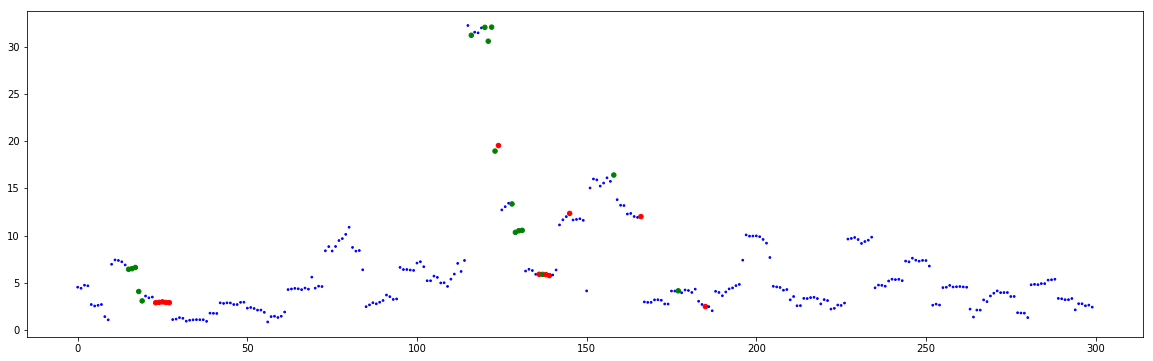

In [112]:
plot_var(train_volume_volatility, label_train, 300)

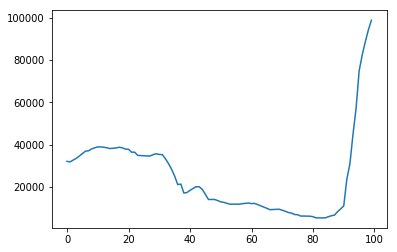

In [45]:
plt.plot(train_price_volatility[:100])

In [55]:
np.savetxt('X_train_feature1.csv', X_train, delimiter=',')
np.savetxt('X_up_test_feature1.csv', X_up_test, delimiter=',')
np.savetxt('X_down_test_feature1.csv', X_down_test, delimiter=',')
np.savetxt('X_updown_test_feature1.csv', X_updown_test, delimiter=',')